In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model #draw graphs
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt #draw graphs
import os
from sklearn.model_selection import train_test_split # to create train, test, validation datasets
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for data preprocessing, image augmentation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3 #transfer learning model
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd

RestNet for classification: Frezzing all the layers and adding the last layer according to class


In [2]:
base_model = tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model.layers:
  layer.trainable = False

2021-11-18 16:00:31.223783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:00:31.331311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:00:31.332057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:00:31.333212: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [3]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(5, activation = 'softmax')(x)

In [4]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [5]:
ROOT_DIR = '../input/cassava-leaf-disease-classification/'
TRAIN_DIR = ROOT_DIR + '/train_images/'
TEST_DIR = ROOT_DIR + '/test_images/'

Train, Test and Validation data creating

In [6]:
all_data_frame = pd.read_csv(ROOT_DIR + 'train.csv')
all_data_frame = all_data_frame.astype({"label": str})
other_data_frame, test_data_frame = train_test_split(
                        all_data_frame, 
                        test_size = 0.2, 
                        random_state = 2000)
print("test data size : "+str(test_data_frame.shape[0]))

test data size : 4280


In [7]:
train_data_frame, validation_data_frame = train_test_split(
                    other_data_frame, 
                    test_size = 0.2, 
                    random_state = 2000)

print("train data size : "+str(train_data_frame.shape[0]))
print("validation data size : "+str(validation_data_frame.shape[0]))

train data size : 13693
validation data size : 3424


Data augmentation


In [8]:
train_image_data_generator = ImageDataGenerator(
                    rotation_range = 270, 
                    zoom_range = [0.05,1.0],
                    shear_range = 0.3, 
                    brightness_range = [0.5,1.5],
                    horizontal_flip = True,
                    vertical_flip = True,
                    width_shift_range = 0.4, 
                    height_shift_range = 0.4, 
                    fill_mode = 'nearest'
)

In [9]:
train_data_frame_iterator = train_image_data_generator.flow_from_dataframe(
                    train_data_frame,
                    directory = TRAIN_DIR,
                    x_col = "image_id",
                    y_col = "label",
                    target_size = (32,32),
                    class_mode = "sparse",
                    batch_size = 32,
                    shuffle = True,
                    seed = 2000,
                    interpolation = "nearest"
)

Found 13693 validated image filenames belonging to 5 classes.


In [10]:
validation_data_frame_iterator =  ImageDataGenerator().flow_from_dataframe(
                    validation_data_frame,
                    directory = TRAIN_DIR,
                    x_col = "image_id",
                    y_col = "label",
                    target_size = (32,32),
                    class_mode = "sparse",
                    batch_size = 32,
                    shuffle = True,
                    seed = 2000,
                    interpolation = "nearest"
)

Found 3424 validated image filenames belonging to 5 classes.


In [11]:
test_data_frame_iterator =  ImageDataGenerator().flow_from_dataframe(
                    test_data_frame,
                    directory = TRAIN_DIR,
                    x_col = "image_id",
                    y_col = "label",
                    target_size = (32,32),
                    class_mode = "sparse",
                    batch_size = 32,
                    shuffle = False,
                    seed = 2000,
                    interpolation = "nearest"
)

Found 4280 validated image filenames belonging to 5 classes.


In [12]:
# Stop training when a monitored metric has stopped improving. usefull to prevent overfitting
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 4,
                               mode = 'min',
                               restore_best_weights = True)

# To save the Keras model in h5 format for future use.
model_checkpoint = ModelCheckpoint('model_vgg16.h5', 
                             monitor = 'val_accuracy',
                             mode = 'max', 
                             save_best_only = True)

# When a measure no longer improves, slow down its learning rate.
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.3,
                              patience = 3,
                              mode = 'min')
TRAIN_STEPS_PER_EPOCH = train_data_frame_iterator.n//train_data_frame_iterator.batch_size
VALIDATION_STEPS_PER_EPOCH = validation_data_frame_iterator.n//validation_data_frame_iterator.batch_size
TEST_STEPS_PER_EPOCH = test_data_frame_iterator.n//test_data_frame_iterator.batch_size

In [13]:
head_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

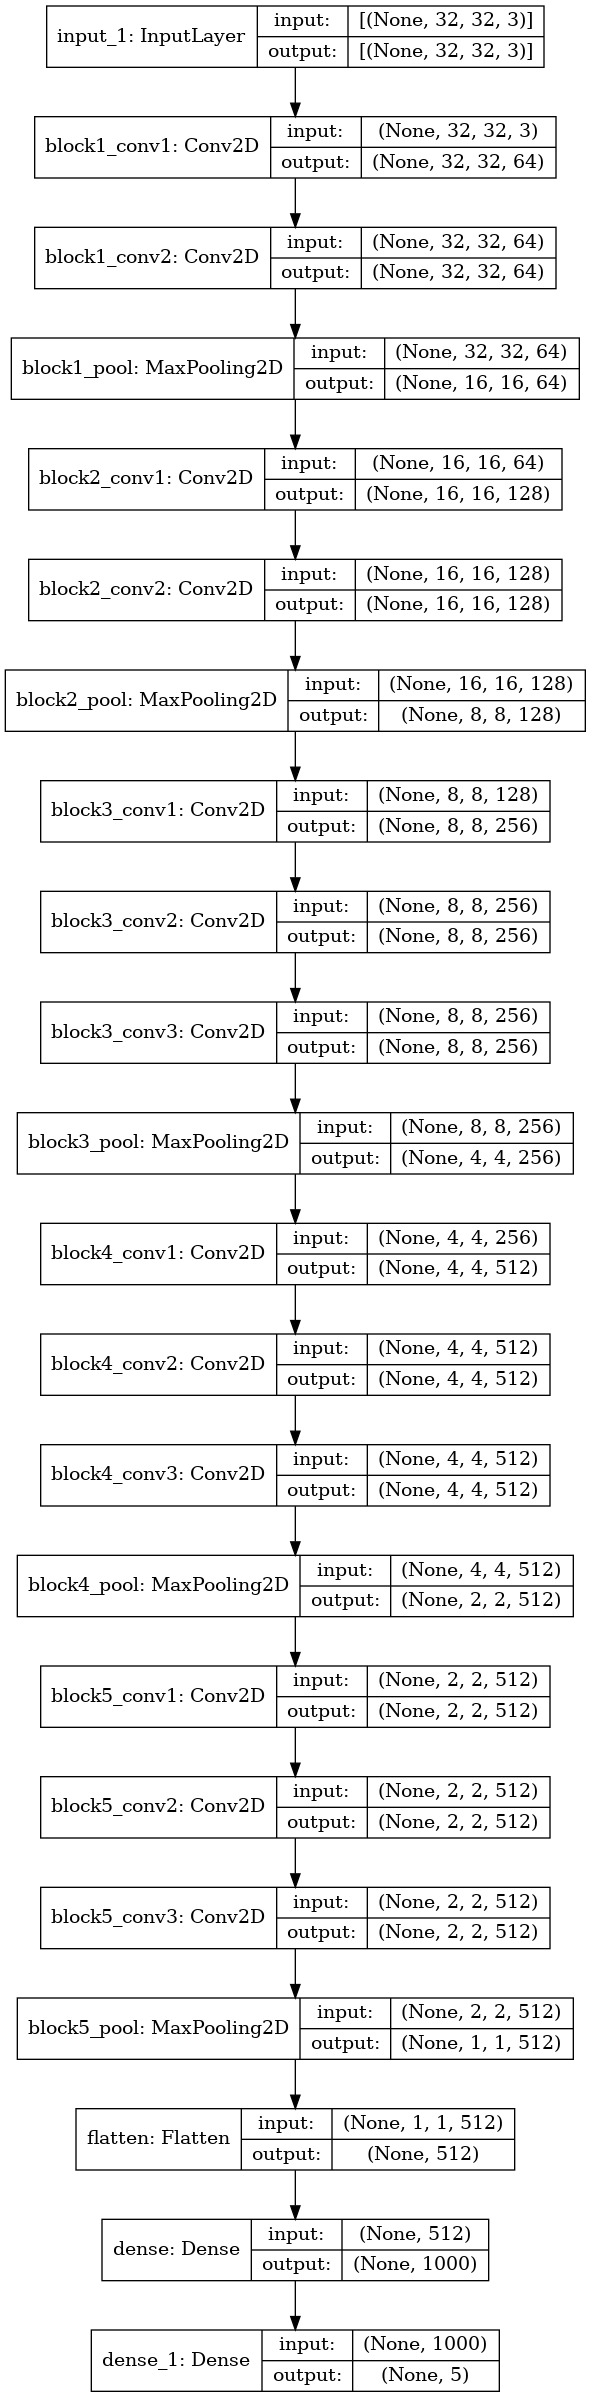

In [14]:
plot_model(head_model, show_shapes = True)

In [15]:
history = head_model.fit(train_data_frame_iterator,
                    validation_data = validation_data_frame_iterator,
                    epochs = 20,
                    steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
                    validation_steps = VALIDATION_STEPS_PER_EPOCH,
                    callbacks = [reduce_learning_rate,model_checkpoint,early_stopping]
                   )


2021-11-18 16:00:47.676885: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-18 16:00:49.414270: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


427/427 [==============================] - 196s 444ms/step - loss: 3.9418 - accuracy: 0.4853 - val_loss: 1.5313 - val_accuracy: 0.5824
Epoch 2/20
427/427 [==============================] - 136s 318ms/step - loss: 1.3163 - accuracy: 0.5807 - val_loss: 1.2313 - val_accuracy: 0.5935
Epoch 3/20
427/427 [==============================] - 138s 323ms/step - loss: 1.1842 - accuracy: 0.6102 - val_loss: 1.1132 - val_accuracy: 0.6329
Epoch 4/20
427/427 [==============================] - 136s 318ms/step - loss: 1.1614 - accuracy: 0.6157 - val_loss: 1.1438 - val_accuracy: 0.6162
Epoch 5/20
427/427 [==============================] - 137s 320ms/step - loss: 1.1448 - accuracy: 0.6158 - val_loss: 1.1139 - val_accuracy: 0.6241
Epoch 6/20
427/427 [==============================] - 136s 319ms/step - loss: 1.1411 - accuracy: 0.6177 - val_loss: 1.0878 - val_accuracy: 0.6314
Epoch 7/20
427/427 [==============================] - 136s 318ms/step - loss: 1.1366 - accuracy: 0.6192 - val_loss: 1.1042 - val_accura

In [16]:
validation_loss, validation_accuracy = head_model.evaluate(validation_data_frame_iterator, steps = VALIDATION_STEPS_PER_EPOCH)
print("validation accuracy: {:5.2f}%".format(100 * validation_accuracy))

107/107 [==============================] - 25s 235ms/step - loss: 1.0552 - accuracy: 0.6390
validation accuracy: 63.90%


In [17]:
test_loss, test_accuracy = head_model.evaluate(test_data_frame_iterator, steps = TEST_STEPS_PER_EPOCH)
print("test accuracy: {:5.2f}%".format(100 * test_accuracy))

133/133 [==============================] - 55s 416ms/step - loss: 1.0743 - accuracy: 0.6309
test accuracy: 63.09%


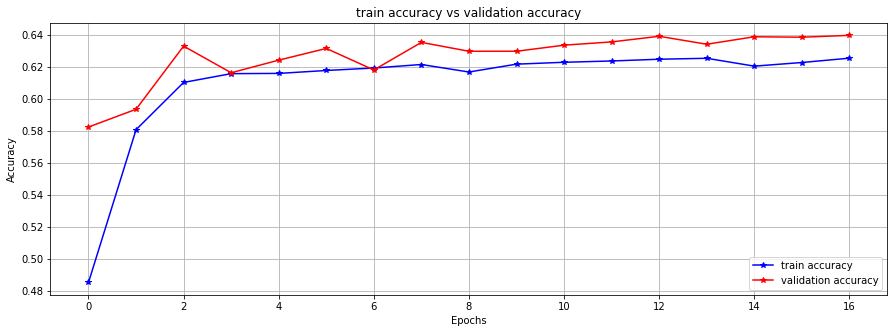

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], 'b*-', label="train accuracy")
plt.plot(history.history['val_accuracy'], 'r*-', label="validation accuracy")
plt.grid()
plt.title("train accuracy vs validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

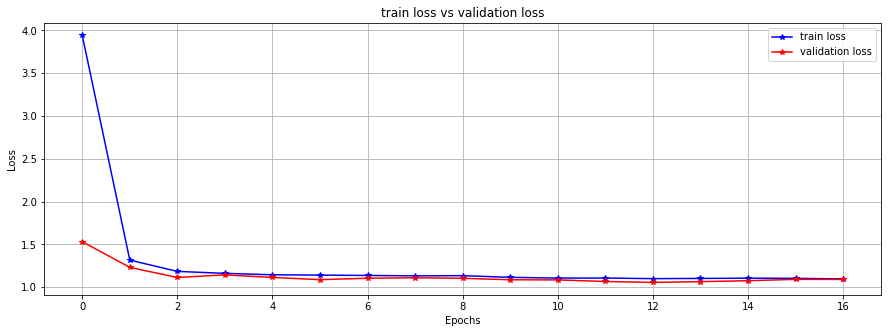

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], 'b*-', label="train loss")
plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
plt.grid()
plt.title("train loss vs validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()